Imports necessary libraries

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import csv
import json
import nltk
import numpy as np
import pickle

In [2]:
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Mounts Drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Creates threeStageAlgorithm function and getDeltaQ helper function

In [4]:
def getDeltaQ(key1, key2, communities, node2degrees, graph, m):
  deltaQ = 0
  for vi in communities[key1]:
    neighbors = set(graph.adj[vi])
    for vj in communities[key2]:
      aij = 1 if vj in neighbors else 0
      deltaQ += (aij - node2degrees[vi]*node2degrees[vj]/(2*m))
  return deltaQ / (2*m)

# Takes in an undirected graph, and returns a dictionary where each key is a
# central node of a community and each value is a list of nodes in that
# community
def threeStageAlgorithm(graph, saveDistances=False, pathToDistances=None, saveSimilarities=False, pathToSimilarities=None):
  # Gets the number of nodes along with the degree of each node
  minNode = min(graph.nodes)
  maxNode = max(graph.nodes)
  degrees = [(k,v) for k,v in graph.degree]
  degrees.sort(key=lambda x : x[1],reverse=True)
  node2degrees = {k:v for k,v in degrees}
  n = len(degrees)

  # Creates an array of all distances between pairs of nodes if necessary
  if pathToDistances == None:
    distances = [[None for _ in range(n+1)] for _ in range(n+1)]
    for u in tqdm(range(minNode, maxNode), leave=False, desc='Creating distances array'):
      for v in range(u+1,maxNode+1):
        try:
          pathLength = len(nx.shortest_path(graph, u, v))-1
          distances[u][v] = pathLength
          distances[v][u] = pathLength
        except:
          continue
    
    if saveDistances:
      with open(pathToDistances, 'wb') as f:
        pickle.dump(distances, f)
  
  # Read in an array of the distances between each pair of nodes
  else:
    with open(pathToDistances, 'rb') as f:
      distances = pickle.load(f)

  # Finds the number of pairs that are not connected
  notConnected = 0
  for u in range(minNode,minNode):
    for v in range(u+1,maxNode+1):
      if distances[u][v] == None:
        notConnected += 1
  
  connected = n*(n-1) - notConnected

  # Finds the sum of the distances
  sumDists = 0
  for u in range(minNode,maxNode):
    for v in range(u+1,maxNode+1):
      if distances[u][v] != None:
        sumDists += distances[u][v]

  # Finds the average distance between every pair of connected nodes
  D = 2*sumDists/connected

  # Selected all the central nodes and places them in set C0
  C0 = set([degrees[0][0]])
  for vj, _ in tqdm(degrees[1:], leave=False, desc='Finding central nodes'):
    for v in C0:
      if distances[v][vj] == None or distances[v][vj] >= D:
        C0.add(vj)
        break
  
  # Creates the dictionary of communities
  communities = {n:[n] for n in C0}

  # Creates an array of similarities between every pair of nodes in a graph if
  # necessary
  if pathToSimilarities == None:
    similarities = [[None for _ in range(n+1)] for _ in range(n+1)]
    for u in tqdm(range(minNode,maxNode), leave=False, desc='Creating similarities array'):
      uNeighbors = graph.adj[u]
      uDegree = node2degrees[u]
      for v in range(u+1,maxNode+1):
        vNeighbors = graph.adj[v]
        vDegree = node2degrees[v]
        if (uDegree + vDegree) > 0:
          similarities[u][v] = 2*len(list(set(uNeighbors).intersection(set(vNeighbors))))/(uDegree + vDegree)
          similarities[v][u] = similarities[u][v]
    if saveSimilarities:
      with open(pathToSimilarities, 'wb') as f:
        pickle.dump(similarities, f)

  # Reads in an array of similarities between every pair of nodes in a graph
  else:
    with open(pathToSimilarities,'rb') as f:
      similarities = pickle.load(f)

  # Adds each node that has not been labeled yet to a pre-community
  notLabeled = set(list(range(minNode,maxNode+1))) - C0
  for _ in tqdm(range(len(list(notLabeled))), leave=False, desc='Adding nodes to communities'):
    maxSim = 0
    for v in C0:
      for vj in notLabeled:
        if similarities[v][vj] != None and similarities[v][vj] > maxSim:
          bestCentralNode = v
          bestNewNode = vj
          maxSim = similarities[v][vj]
    communities[bestCentralNode].append(vj)
    notLabeled.remove(vj)

  # Deletes distances and similarities arrays because they will no longer be
  # used (and they're usually very large)
  del distances
  del similarities

  # Calculates the average degree of every node divided by 2
  m = 0
  for v in range(minNode,maxNode+1):
    m += node2degrees[v]
  m /= 2

  # Calculates the change in modularity we would get if we merged each pair of
  # communities
  deltaQs = []
  keys = list(communities.keys())
  merged = {k:False for k in keys}
  for i in tqdm(range(len(keys)-1),leave=False, desc='Calculating changes in modularities'):
    key1 = keys[i]
    for j in range(i+1, len(keys)):
      key2 = keys[j]
      deltaQ = getDeltaQ(key1, key2, communities, node2degrees, graph, m)
      if deltaQ >= 0:
        deltaQs.append([deltaQ, key1, key2])

  # Merges communities to maximize modularity
  deltaQs.sort(key=lambda x : x[0], reverse=True)
  length = len(deltaQs)
  idx = 0
  for idx in tqdm(range(length), leave=False, desc='Merging communities'):
    key1 = deltaQs[idx][1]
    key2 = deltaQs[idx][2]
    if not(merged[key1]) and not(merged[key2]):
      merged[key1] = True
      merged[key2] = True
      communities[key1] = communities[key1] + communities[key2]
      communities.pop(key2)
  
  new_communities = {}
  for idx, item in enumerate(communities.items()):
    new_communities[idx] = item[1]

  return new_communities

Reads docmap file and generates a list of all documents. Each document is represented as a list with 3 elements: the node index, the document id, and the document name

In [5]:
docMapPath = 'drive/My Drive/CS 6850 Final Project/Data/docmap'
file=open(docMapPath,"r")
docMapStrings = file.read().split('\n')
docMapStrings = list(map(lambda x : x.split('\t'), docMapStrings))
docMap = []
for index, line in enumerate(docMapStrings):
  docMap.append([index+1, int(line[0]), line[1]])

Reads pair_doc file and generate a list of all the edges. Each edge is represented as a list of 2 elements: the source node and the destination node.

In [6]:
edgesPath = 'drive/My Drive/CS 6850 Final Project/Data/pair_doc'
file=open(edgesPath,"r")
edgesStrings = file.read().split('\n')
edgesStrings = list(map(lambda x : x.split(' '), edgesStrings))
edgesStrings=  list(filter(lambda x : x != [''], edgesStrings))
edges = []
for line in edgesStrings:
  edges.append([int(line[0]), int(line[1])])

Checks if the node indices are 0-indexed or 1-indexed by seeing if 0 is used in the edges.

In [7]:
for edge in edges:
  if 0 in edge:
    print(edge)

Creates a directed graph, directedG, and an undirected graph, undirectedG1. directedG will contains all edges in the original dataset. undirectedG1 will only contain edges between nodes u and v if there is one edge going from u to v and one edge going from v to u in the dataset.

In [8]:
directedG = nx.DiGraph()
undirectedG1 = nx.Graph()

Adds all nodes to both graphs

In [9]:
for doc in docMap:
  directedG.add_node(doc[0], id=doc[1], name=doc[2])
  undirectedG1.add_node(doc[0], id=doc[1], name=doc[2])

Adds all edges to directedG, and adds necessary edges to undirectedG1

In [10]:
edgesSeen = set()
for edge in edges:
  u = edge[0]
  v = edge[1]
  directedG.add_edge(u, v)
  if str([v, u]) in edgesSeen:
    undirectedG1.add_edge(u, v)
  else:
    edgesSeen.add(str(edge))

Creates another undirected graph, undirectedG2. This graph contains all the edges from directedG, except that they have been converted to undirected edges, and duplicate undirected edges between nodes were removed

In [11]:
undirectedG2 = directedG.to_undirected()

Checks that the number of edges in all graphs ia correct

In [12]:
assert(directedG.number_of_edges() == undirectedG1.number_of_edges() + undirectedG2.number_of_edges())

Makes sure each graph has the correct number of edges

In [13]:
edgesSeen = set()
undirectedG1Edges = undirectedG1.edges
undirectedG2Edges = undirectedG2.edges
for edge in directedG.edges:
  u = edge[0]
  v = edge[1]
  assert (edge in undirectedG2Edges)
  if str((v,u)) in edgesSeen:
    assert (edge in undirectedG1Edges)
  else:
    edgesSeen.add(str(edge))

In [14]:
def generateLayerGraph(communities, childGraph):
  graph = nx.Graph()
  keys = list(communities.keys())
  for k in keys:
    graph.add_node(k)
  
  length = len(keys)
  for u in range(length-1):
    key1 = keys[u]
    uNodes = set(communities[key1])
    for v in range(u+1,length):
      key2 = keys[v]
      for vNode in communities[key2]:
        vNeighbors = set(childGraph.adj[vNode])
        if uNodes.intersection(vNeighbors) != set():
          graph.add_edge(u,v)
          break
  
  return graph

In [15]:
def combineLayers(layers, communities):
  graph = nx.DiGraph()
  n = len(layers)
  root = str((n, 0))
  graph.add_node(root)
  layers.reverse()
  communities.reverse()
  treeLayer = n
  for idx, curGraph in enumerate(layers[1:-1]):
    treeLayer = treeLayer - 1
    for node in curGraph.nodes:
      graph.add_node(str((treeLayer, node)))

    curCommunities= communities[idx]
    for k, v in curCommunities.items():
      for node in v:
        graph.add_edge(str((treeLayer+1, k)), str((treeLayer, node)))
    
  for node in layers[-1].nodes:
    graph.add_node(node)
  
  curCommunities = communities[-1]
  for k, v in curCommunities.items():
    for node in v:
      graph.add_edge(str((2, k)), node)

  return graph, root

Creates a function that takes in a list of layers and communitites and creates a tree

In [16]:
def generateTree(leafGraph, algorithm):
  layers = [leafGraph]
  curCommunities = algorithm(leafGraph)
  communities = [curCommunities]
  layers.append(generateLayerGraph(communities[0], leafGraph))
  prevLayerLength = len(list(layers[0].nodes))
  iteration = 0
  while len(communities[-1].items()) > 1 and len(communities[-1].items()) < prevLayerLength:
    iteration += 1
    print(iteration)
    prevLayerLength = len(list(layers[-1].nodes))
    communities.append(algorithm(layers[-1]))
    layers.append(generateLayerGraph(communities[-1], layers[-1]))

  tree, root = combineLayers(layers, communities)

  return tree, root, layers, communities

In [42]:
root = list(TSAGraph.nodes)[0]
while set(TSAGraph.predecessors(root)) != set():
  root = set(TSAGraph.predecessors(root))[0]

In [46]:
print(root)
print(TSAGraph.degree[root])

(7, 0)
998


Gets TSA graph

In [17]:
try:
  with open('drive/My Drive/CS 6850 Final Project/TSA/layers.pkl', 'rb') as f:
    layers = pickle.load(f)
  with open('drive/My Drive/CS 6850 Final Project/TSA/communities.pkl', 'rb') as f:
    communities = pickle.load(f)
  with open('drive/My Drive/CS 6850 Final Project/TSA/tree.pkl', 'rb') as f:
    TSAGraph = pickle.load(f)
  # with open('drive/My Drive/CS 6850 Final Project/TSA/root.pkl', 'rb') as f:
  #   root = pickle.load(f)
except:
  stop('error')

Gets Wikipedia category graph

In [18]:
with open('drive/My Drive/CS 6850 Final Project/wiki_category_trimmed_bsf_tree.json') as f:
    trimmed_edges_list = json.load(f)

WikiGraph = nx.DiGraph()
for n1, n2 in tqdm(trimmed_edges_list):
    WikiGraph.add_edge(n1, n2)

100%|██████████| 14868/14868 [00:00<00:00, 67665.04it/s]


The following part computes the semantic relatedness scores using the trees we have

In [19]:
# Loads a dictionary from names of articles to their ID in the Wikipedia graph
with open('drive/My Drive/CS 6850 Final Project/updates_page_names.json') as f:
    names2Wiki_id = json.load(f)

In [20]:
# Get a list of all article names
all_names = list(map(lambda x : x.replace('_', ' '), names2Wiki_id.keys()))

In [21]:
# Creates a dictionary from names of articles to their ID in the TSA graph
names = list(map(lambda x : x[2].replace('_', ' '), docMap))
names2TSA_id = {name: names.index(name)+1 for name in all_names}

In [22]:
words = list(map(lambda x : wn.synsets(x)[0], all_names))

In [23]:
word2Name = {word:name for name, word in zip(all_names, words)}

In [24]:
def wup_similarity(graph, node_id1, node_id2):
  root = node_id1
  while list(graph.predecessors(root)) != []:
    root = list(graph.predecessors(root))[0]
  node1_paths = list(nx.algorithms.all_simple_paths(graph, source=root, target=node_id1))
  node2_paths = list(nx.algorithms.all_simple_paths(graph, source=root, target=node_id2))
  lcsDepth = 0
  for node1_path in node1_paths:
    for node2_path in node2_paths:
      idx = 0
      n = min(len(node1_path), len(node2_path))
      while idx < n and node1_path[idx] == node2_path[idx]:
        idx += 1
      commonParent = node1_path[idx-1]
      commonParentDepth = nx.algorithms.shortest_path_length(graph, source=root, target=commonParent)
      if commonParentDepth > lcsDepth:
        lcsDepth = commonParentDepth
  
  node1Depth = nx.algorithms.shortest_path_length(graph, source=root, target=node_id1)
  node2Depth = nx.algorithms.shortest_path_length(graph, source=root, target=node_id2)
  return 2*lcsDepth/(node1Depth + node2Depth)

In [25]:
def getModularity(graph, communities):
  modularity = 0
  m = len(list(graph.edges))
  for _, nodes in communities.items():
    n_nodes = len(nodes)
    if n_nodes > 1:
      for i in range(n_nodes-1):
        neighbors = set(graph.adj[nodes[i]])

        for j in range(i+1, n_nodes):
          a = 1 if nodes[j] in neighbors else 0
          modularity += a - graph.degree[nodes[i]]*graph.degree[nodes[j]]/(2*m)
  modularity /= 2*m
  return modularity

In [26]:
for graph, comm in zip(layers, communities):
  print(getModularity(graph, comm))

0.07388390396836707
0.05413942167197443
0.028030101426515498
0.030370931684179387
0.0327618816000214
0.06311386516671168


<BarContainer object of 4 artists>

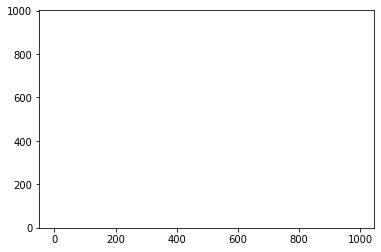

In [27]:
comm =  communities[-2]
sizes = {}
for v in comm.values():
  size = len(v)
  if size in sizes:
    sizes[size] += 1
  else:
    sizes[size] = 1
# new_sizes = {v:k for k, v in sizes.items()}
# x_min = min(new_sizes.values())
# x_max = max(new_sizes.values())
# counts = []
# for i in range(x_min, x_max+1):
#   if i in new_sizes:
#     counts.append(new_sizes[i])
#   else:
#     counts.append(0)
all_items = list(sizes.items())
k = list(map(lambda x : x[0], all_items))
v = list(map(lambda x : x[1], all_items))
plt.bar(v, k)


In [28]:
try:
  with open('drive/My Drive/CS 6850 Final Project/wikiSimilarities.pkl', 'rb') as f:
    WikiSimilarities = pickle.load(f)
  with open('drive/My Drive/CS 6850 Final Project/wordnetSimilarities.pkl', 'rb') as f:
    wordnetSimilarities = pickle.load(f)
  with open('drive/My Drive/CS 6850 Final Project/TSASimilarities.pkl', 'rb') as f:
    TSASimilarities = pickle.load(f)
except:
  print('error')
  n = len(words)
  wordnetSimilarities = []
  TSASimilarities = []
  WikiSimilarities = []
  for i in tqdm(range(n-1), leave=False):
    name1 = word2Name[words[i]]
    TSA1 = names2TSA_id[name1]
    Wiki1 = names2Wiki_id[name1.replace(' ', '_')]
    for j in range(i+1,n):
      wordnetSim = words[i].wup_similarity(words[j])
      if wordnetSim != None:
        wordnetSimilarities.append(wordnetSim)
        name2 = word2Name[words[j]]
        TSA2 = names2TSA_id[name2]
        Wiki2 = names2Wiki_id[name2.replace(' ', '_')]
        TSASimilarities.append(wup_similarity(TSAGraph, TSA1, TSA2))
        WikiSimilarities.append(wup_similarity(WikiGraph, Wiki1, Wiki2))

In [33]:
docMap[:5]

[[1, 5323, 'Computer_science'],
 [2, 169633, 'Topic_outline_of_computer_science'],
 [3, 328784, 'Computer_scientist'],
 [4, 900765, 'Program_(mathematical_object)'],
 [5, 1180800, 'Overlapping_subproblem']]

In [29]:
with open('drive/My Drive/CS 6850 Final Project/CIDLPA_tree.pkl', 'rb') as f:
    CIDLPA_tree = pickle.load(f)

In [38]:
n = len(words)
CIDLPASimilarities = []
for i in tqdm(range(n-1), leave=False):
  name1 = word2Name[words[i]]
  TSA_id1 = names2TSA_id[name1.replace(' ', '_')]
  print(TSA_id1)
  for j in range(i+1,n):
    wordnetSim = words[i].wup_similarity(words[j])
    if wordnetSim != None:
      name2 = word2Name[words[j]]
      TSA_id2 = names2TSA_id[name2.replace(' ', '_')]
      print(TSA_id2)
      example = wup_similarity(TSAGraph, TSA_id1, TSA_id2)
      CIDLPASimilarities.append(wup_similarity(CIDLPA_tree, Wiki1, Wiki2))

  0%|          | 0/158 [00:00<?, ?it/s]

5942
12914


NetworkXNoPath: ignored

In [ ]:
allSimilarities = np.array([wordnetSimilarities, TSASimilarities, WikiSimilarities])

In [ ]:
np.corrcoef(allSimilarities)

In [ ]:
plt.scatter(wordnetSimilarities, TSASimilarities)

In [ ]:
plt.scatter(wordnetSimilarities, WikiSimilarities)

In [ ]:
plt.scatter(WikiSimilarities, TSASimilarities)

In [ ]:
with open('drive/My Drive/CS 6850 Final Project/wikiSimilarities.pkl', 'wb') as f:
  pickle.dump(WikiSimilarities, f)
with open('drive/My Drive/CS 6850 Final Project/wordnetSimilarities.pkl', 'wb') as f:
  pickle.dump(wordnetSimilarities, f)
with open('drive/My Drive/CS 6850 Final Project/TSASimilarities.pkl', 'wb') as f:
  pickle.dump(TSASimilarities, f)

Information about three-stage algorithm tree:

Depth: 5

Average branching factor: 1.84
